In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rioxr
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

import pystac_client 
import planetary_computer as pc

#import iceplant_detection_functions as ipf
import lidar_sampling_functions as lsf

# Import & prepare campus lagoon 2018 data (spectral + lidar)

In [61]:
fp = os.path.join(os.getcwd(),'campus_lagoon_2018_lidar.csv')
df = pd.read_csv(fp)
df.head(3)

,Unnamed: 0,iceplant,r,g,b,nir,year,month,day,naip_id,polygon_id,geometry,lidar,max_lidar_w,min_lidar_w,min_max_diff,avg_lidar_w
0,0,1,93,88,93,141,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,0,POINT (238343.42981319653 3810848.805207873),4,5,2,3,3.333333
1,1,1,85,85,89,137,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,0,POINT (238343.54673072172 3810846.093093588),4,5,2,3,3.333333
2,2,1,89,85,91,133,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,0,POINT (238344.86438268572 3810845.534717399),4,5,2,3,3.333333


In [62]:
df.drop(['Unnamed: 0','month','day','year','naip_id','polygon_id'], axis=1,inplace=True)
df.head(3)

,iceplant,r,g,b,nir,geometry,lidar,max_lidar_w,min_lidar_w,min_max_diff,avg_lidar_w
0,1,93,88,93,141,POINT (238343.42981319653 3810848.805207873),4,5,2,3,3.333333
1,1,85,85,89,137,POINT (238343.54673072172 3810846.093093588),4,5,2,3,3.333333
2,1,89,85,91,133,POINT (238344.86438268572 3810845.534717399),4,5,2,3,3.333333


In [63]:
df['ndvi']=(df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
df.head(3)

,iceplant,r,g,b,nir,geometry,lidar,max_lidar_w,min_lidar_w,min_max_diff,avg_lidar_w,ndvi
0,1,93,88,93,141,POINT (238343.42981319653 3810848.805207873),4,5,2,3,3.333333,0.205128
1,1,85,85,89,137,POINT (238343.54673072172 3810846.093093588),4,5,2,3,3.333333,0.234234
2,1,89,85,91,133,POINT (238344.86438268572 3810845.534717399),4,5,2,3,3.333333,0.198198


In [64]:
df = df[['r','g','b','nir','ndvi',
         'lidar','max_lidar_w', 'min_lidar_w', 'min_max_diff', 'avg_lidar_w',
         'iceplant']]
df.head(3)

,r,g,b,nir,ndvi,lidar,max_lidar_w,min_lidar_w,min_max_diff,avg_lidar_w,iceplant
0,93,88,93,141,0.205128,4,5,2,3,3.333333,1
1,85,85,89,137,0.234234,4,5,2,3,3.333333,1
2,89,85,91,133,0.198198,4,5,2,3,3.333333,1


# Functions for rfc mode eval and assemblage
All htese are in another .py

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import fbeta_score

def iceplant_proportions(labels):
    unique, counts = np.unique(labels, return_counts=True)
    print('no-iceplant:iceplant ratio    ',round(counts[0]/counts[1],1),':1')
    n = labels.shape[0]
    perc = [round(counts[0]/n*100,2), round(counts[1]/n*100,2)]
    df = pd.DataFrame({'iceplant':unique,
             'counts':counts,
             'percentage':perc}).set_index('iceplant')
    print(df)
    print()

def test_train_proportions(train_labels, test_labels):
    print('TRAIN SET COUNTS:')
    iceplant_proportions(train_labels)

    print('TEST SET COUNTS:')
    iceplant_proportions(test_labels)

    return

def print_accuracy_info(y_true,y_pred):
    N = y_true.shape[0]
    
    confmtx = confusion_matrix(y_true,y_pred)
    
    print('true negatives:', confmtx[0,0], 
          '    false positives:', confmtx[0,1])
    print('false negatives:', confmtx[1,0], 
          '    true positives:', confmtx[1,1])
    print()
    unique, counts = np.unique(y_true,return_counts=True)
    
    sens =  confmtx[1,1]/counts[1]
    spec =  confmtx[0,0]/counts[0]
    print('sensitivity (TP/P):', np.round(sens*100,2), '%')  
    print('specificity (TN/N):', np.round(spec*100,2), '%')  
    print('G-mean: ', round(np.sqrt(sens*spec),2))
    print()
    
    prec = confmtx[1,1]/(confmtx[1,1]+confmtx[0,1])
    print('precision (TP/(TP+FP)):', np.round(prec*100,2),'%' )
    print()
    
    print('MCC: ', matthews_corrcoef(y_true,y_pred))
    print()
    
    print('F1-measure: ',  round(fbeta_score(y_true, y_pred, beta=1.0),5))
    print('F0.5-measure (min false positives): ',  round(fbeta_score(y_true, y_pred, beta=0.5),5))
    print('F2-measure (min false negatives)  : ',  round(fbeta_score(y_true, y_pred, beta=2.0),5))
    print()
        
    print('accuracy:', np.round( (confmtx[1,1] + confmtx[0,0])/y_true.shape[0]*100,2),'%') # (TP + TN)/(P + N)
    return

# Rfc model with spectral features
## train

In [65]:
y = np.array(df['iceplant'])
X = np.array(df.drop('iceplant', axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [67]:
test_train_proportions(y_train, y_test)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     9.7 :1
          counts  percentage
iceplant                    
0          44017       90.62
1           4556        9.38

TEST SET COUNTS:
no-iceplant:iceplant ratio     10.0 :1
          counts  percentage
iceplant                    
0          18925       90.91
1           1893        9.09



In [68]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## evaluate on test set 

In [20]:
predictions = rfc.predict(X_test)
print_accuracy_info(y_test, predictions)

true negatives: 18914     false positives: 11
false negatives: 22     true positives: 1871

sensitivity (TP/P): 98.84 %
specificity (TN/N): 99.94 %
G-mean:  0.99

precision (TP/(TP+FP)): 99.42 %

MCC:  0.9903917618798886

F1-measure:  0.99126
F0.5-measure (min false positives):  0.99299
F2-measure (min false negatives)  :  0.98953

accuracy: 99.84 %


## feature importance

In [21]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [22]:
forest_importances = pd.Series(result.importances_mean, 
                               index=['r','g','b','nir','ndvi',
                                       'lidar','max_lidar_w', 'min_lidar_w', 'min_max_diff', 'avg_lidar_w'])
forest_importances

r               0.047930
g               0.033778
b               0.015487
nir             0.031180
ndvi            0.005716
lidar           0.002935
max_lidar_w     0.014545
min_lidar_w     0.002392
min_max_diff    0.030209
avg_lidar_w     0.007666
dtype: float64

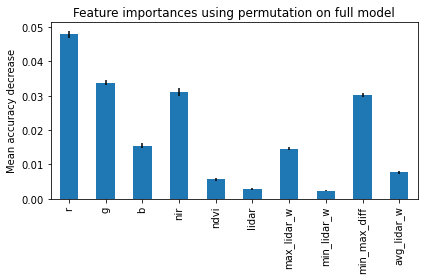

In [23]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Rfc model only with spectral features

## train

In [77]:
df_spectral = df.drop(['lidar','max_lidar_w', 'min_lidar_w', 'min_max_diff', 'avg_lidar_w'],axis=1)
y = np.array(df_spectral['iceplant'])
X= np.array(df_spectral.drop('iceplant', axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [78]:
rfc_spectral = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc_spectral.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## evaluate on test set

In [30]:
predictions = rfc_spectral.predict(X_test)
print_accuracy_info(y_test, predictions)

true negatives: 18803     false positives: 122
false negatives: 98     true positives: 1795

sensitivity (TP/P): 94.82 %
specificity (TN/N): 99.36 %
G-mean:  0.97

precision (TP/(TP+FP)): 93.64 %

MCC:  0.9364638774316778

F1-measure:  0.94226
F0.5-measure (min false positives):  0.93871
F2-measure (min false negatives)  :  0.94583

accuracy: 98.94 %


# Applying lidar model to NAIP aoi

## Open aoi from NAIP scene

In [2]:
aois = gpd.read_file('/home/jovyan/msai4earth-esa/iceplant_detection/areas_of_interest/areas_of_interest.shp')
cl = aois.iloc[4]  # Campus Lagoon aoi
cl

name                                              campus point
region                                                  goleta
itemid_12               ca_m_3411934_sw_11_1_20120505_20120730
itemid_14               ca_m_3411934_sw_11_1_20140601_20141030
itemid_16              ca_m_3411934_sw_11_.6_20160713_20161004
itemid_18             ca_m_3411934_sw_11_060_20180722_20190209
itemid_20                      ca_m_3411934_sw_11_060_20200521
geometry     POLYGON ((-119.8534713523 34.4028697719, -119....
Name: 4, dtype: object

In [3]:
#obtain href to NAIP scene
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

search = catalog.search(
        collections=["naip"],
        ids = cl.itemid_18        
    )

item = list(search.get_items())[0]
href = pc.sign(item.assets["image"].href)

In [4]:
# clip NAIP scene to aoi
reduce = aois.iloc[[4]] # retrieve row as gpd GeoDataFrame

ds = rasterio.open(href)

#reduce = gpd.GeoDataFrame({'geometry':[reduce_box]}, crs="EPSG:4326")
reduce = reduce.to_crs(ds.crs)

In [6]:
# rioxarray of complete naip scene (two ways of getting it, second probably better?)
naip_scene = rioxr.open_rasterio(rasterio.open(href))

naip_clip = naip_scene.rio.clip_box(*reduce.total_bounds)
naip_clip

<xarray.DataArray (band: 4, y: 1925, x: 1969)>
[15161300 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 2.377e+05 2.377e+05 ... 2.389e+05 2.389e+05
  * y            (y) float64 3.812e+06 3.812e+06 3.812e+06 ... 3.81e+06 3.81e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

## Open LIDAR raster & create features

In [7]:
fp = os.path.join(os.getcwd(),'3mlidar_over_campuspoint_naip_scene.tif')
lidar = rioxr.open_rasterio(fp)

In [9]:
# fp = os.path.join(os.getcwd(),'3mlidar_over_campuspoint_naip_scene.tif')
# lidar_rast_r = rasterio.open(fp)
# lsf.save_min_max_diff_rasters(lidar_rast_r, os.getcwd())
# lsf.save_avg_rasters(lidar_rast_r, os.getcwd())

## Match features to naip_clip (aoi)

In [10]:
lidar_match = lidar.rio.reproject_match(naip_clip)
lidar_match = lidar_match.squeeze()
#lidar_match

In [11]:
fp = os.path.join(os.getcwd(),'lidar_avgs.tif')
avg = rioxr.open_rasterio(fp)
avg_match = avg.rio.reproject_match(naip_clip)
avg_match = avg_match.squeeze()
#avg_match

In [12]:
fp = os.path.join(os.getcwd(),'lidar_diffs.tif')
diff = rioxr.open_rasterio(fp)
diff_match = diff.rio.reproject_match(naip_clip)
diff_match = diff_match.squeeze()
#diff_match

<xarray.DataArray (y: 1925, x: 1969)>
array([[6, 6, 6, ..., 2, 2, 2],
       [6, 6, 6, ..., 2, 2, 2],
       [6, 6, 6, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * x            (x) float64 2.377e+05 2.377e+05 ... 2.389e+05 2.389e+05
  * y            (y) float64 3.812e+06 3.812e+06 3.812e+06 ... 3.81e+06 3.81e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    255

In [13]:
fp = os.path.join(os.getcwd(),'lidar_maxs.tif')
maxs = rioxr.open_rasterio(fp)
maxs_match = maxs.rio.reproject_match(naip_clip)
maxs_match = maxs_match.squeeze()
#maxs_match

<xarray.DataArray (y: 1925, x: 1969)>
array([[  7,   7,   7, ...,   2,   2,   2],
       [  7,   7,   7, ...,   2,   2,   2],
       [  7,   7,   7, ...,   2,   2,   2],
       ...,
       [241, 241, 241, ..., 241, 241, 241],
       [241, 241, 241, ..., 241, 241, 241],
       [241, 241, 241, ..., 241, 241, 241]], dtype=uint8)
Coordinates:
  * x            (x) float64 2.377e+05 2.377e+05 ... 2.389e+05 2.389e+05
  * y            (y) float64 3.812e+06 3.812e+06 3.812e+06 ... 3.81e+06 3.81e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    255

In [14]:
fp = os.path.join(os.getcwd(),'lidar_mins.tif')
mins = rioxr.open_rasterio(fp)
mins_match = mins.rio.reproject_match(naip_clip)
mins_match = mins_match.squeeze()
#mins_match

<xarray.DataArray (y: 1925, x: 1969)>
array([[  1,   1,   1, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       ...,
       [241, 241, 241, ..., 241, 241, 241],
       [241, 241, 241, ..., 241, 241, 241],
       [241, 241, 241, ..., 241, 241, 241]], dtype=uint8)
Coordinates:
  * x            (x) float64 2.377e+05 2.377e+05 ... 2.389e+05 2.389e+05
  * y            (y) float64 3.812e+06 3.812e+06 3.812e+06 ... 3.81e+06 3.81e+06
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    255

In [15]:
lidar_minmax_features = np.array([
    lidar_match.to_numpy(),                             
    maxs_match.to_numpy(),
    mins_match.to_numpy(),
    diff_match.to_numpy()])

lidar_minmax_features.shape

(4, 1925, 1969)

In [16]:
# lsf.save_raster(raster= lidar_minmax_features, 
#                 fp = os.path.join(os.getcwd(),'lidar_minmax_features.tif'),
#                 shape = (1925,1969), 
#                 bands_n = 4, 
#                 crs = mins_match.rio.crs,
#                 transform= mins_match.rio.transform(),
#                 dtype = rasterio.uint8)

In [17]:
# lsf.save_raster(raster= avg_match, 
#                 fp = os.path.join(os.getcwd(),'lidar_avg_features.tif'),
#                 shape = (1925,1969), 
#                 bands_n = 1, 
#                 crs = mins_match.rio.crs,
#                 transform= mins_match.rio.transform(),
#                 dtype = rasterio.float32)

## Sample spectral features

In [20]:
import iceplant_detection_functions_Copy1 as ipf

In [21]:
# select pixel with vegetation
image = naip_clip.to_numpy()  
veg = ipf.select_ndvi_df(image) 
veg

/home/jovyan/msai4earth-esa/iceplant_detection/model_with_lidar/iceplant_detection_functions_Copy1.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'], axis=1, inplace=True)


,r,g,b,nir
19,33,43,62,37
25,116,105,108,135
26,114,104,103,146
27,118,108,110,153
28,122,114,111,162
...,...,...,...,...
3788597,44,53,67,64
3788598,41,52,65,56
3788599,39,50,65,46
3788600,38,50,64,46


In [55]:
# add ndvi as spectral feature
veg['ndvi']=(veg.nir.astype('int16') - veg.r.astype('int16'))/(veg.nir.astype('int16') + veg.r.astype('int16'))

## Sample LIDAR features

In [22]:
# fp =  os.path.join(os.getcwd(),'lidar_minmax_features.tif')
# lidar_minmax = rasterio.open(fp).read()

# fp = os.path.join(os.getcwd(),'lidar_avg_features.tif')
# lidar_avg = rasterio.open(fp).read()

In [52]:
d = lidar_minmax_features.reshape([4,-1]).T
df_lidar = pd.DataFrame(d, columns=['lidar','max','min','diff'])
df_lidar['avg'] = avg_match.reshape(avg_match.shape[0]*avg_match.shape[1])

df_lidar = df_lidar.iloc[veg.index]

## Complete feature df

In [60]:
cl_features = pd.concat([veg,df_lidar],axis=1).to_numpy()

## LIDAR rfc model predictions

In [69]:
predictions = rfc.predict(cl_features)

In [74]:
# attach predictions to index of analyzed pixels
is_iceplant = pd.DataFrame(predictions, columns=['is_iceplant'], index=veg.index)

# select pixels classified as iceplant
is_iceplant = is_iceplant[is_iceplant.is_iceplant == 1]

,is_iceplant
1082,1
1083,1
1209,1
5021,1
6985,1
...,...
2935213,1
2935216,1
2935218,1
2935219,1


In [75]:
preds_image = ipf.indices_backto_image(lidar_avg.shape[0], lidar_avg.shape[1], is_iceplant.index)

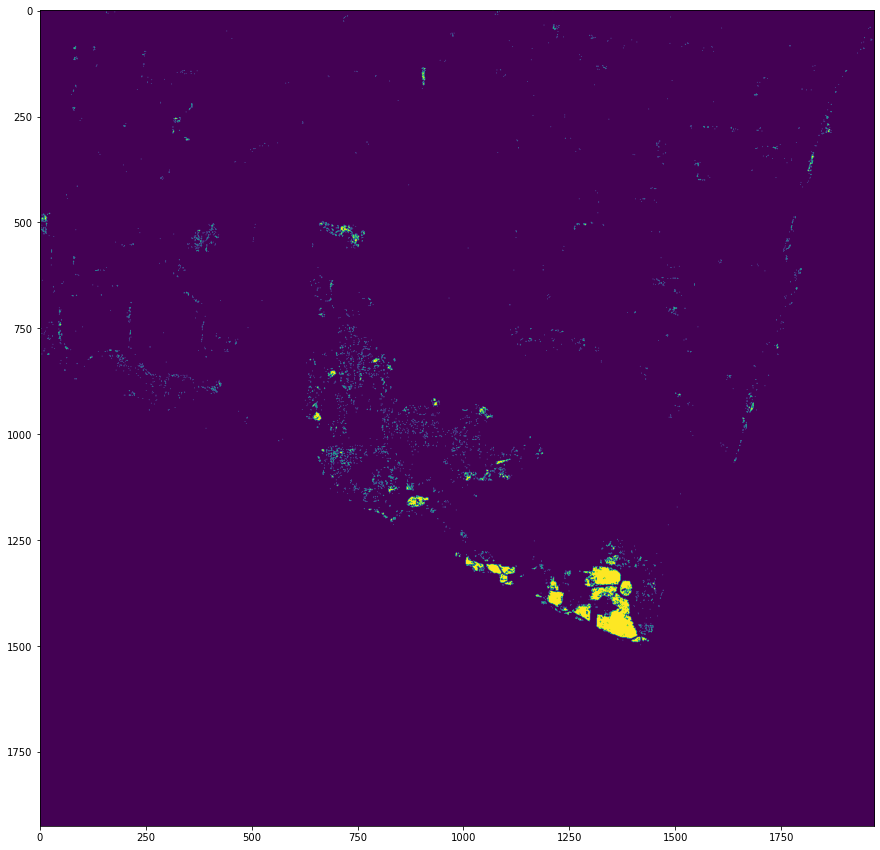

In [85]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(preds_image)
plt.show()

# Applying only spectral rfc model to aoi

In [80]:
spectral_predictions = rfc_spectral.predict(veg.to_numpy())

In [81]:
spec_is_iceplant = pd.DataFrame(spectral_predictions, columns=['is_iceplant'],index=veg.index)
spec_is_iceplant = spec_is_iceplant[spec_is_iceplant.is_iceplant == 1]

,is_iceplant
41,1
80,1
1208,1
1209,1
2011,1
...,...
2933267,1
2935213,1
2935216,1
2935218,1


In [82]:
spec_preds_image = ipf.indices_backto_image(lidar_avg.shape[0],lidar_avg.shape[1],spec_is_iceplant.index)

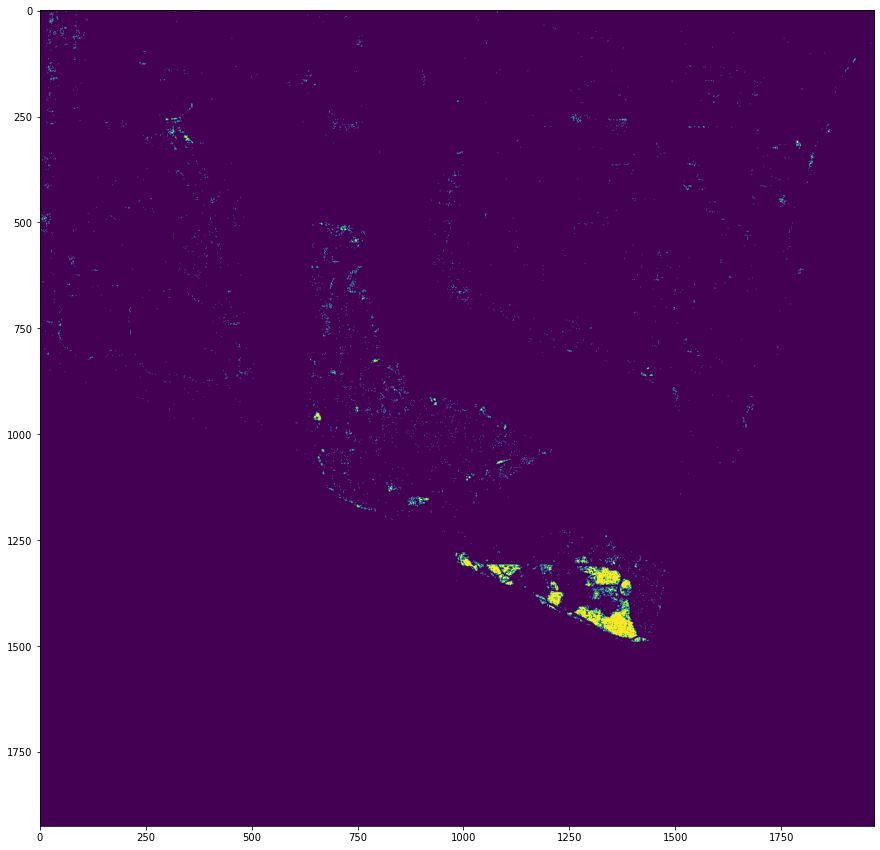

In [84]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(spec_preds_image)
plt.show()